# CS6120 Final Project: Group-14: Label-Correlation Aware Emotion Classification
- In this project we studied the importance of using label-correlation idea in the task of emotion classification using tweets from SemEval dataset.
- We perform the following tasks for this project:
    - clean and preprocess the data,
    - do some exploroatory analysis on the dataset,
    - prepare and train the model with various loss functions,
    - do ablation experiments with loss functions,
    - and draw observations from the results.

### Environment setup

Before beginning the experiments, we do the required environment setup by installing all the required packages for the project

In [ ]:
# package installs
!pip install numpy
!pip install sklearn
!pip install fastprogress==0.2.3
!pip install docopt==0.6.2
!pip install transformers==3.0.2
!pip install pandas==0.24.2
!pip install ekphrasis
!pip install tqdm==4.31.1

### Dataset exploration
In this section, we do the following analysis on the dataset:
- Identify the emotion distribution across the dataset (train, validation, and test splits.)
- Identify the label correlation among train and validaiton splits.

Emotion distribution counts: [ 293. 1481. 4491. 3459. 1073.  170.   16.    0.    0.    0.    0.]
Emotion distribution percentages: [ 2.66775926 13.48447601 40.89046709 31.49412729  9.769644    1.54784667
  0.14567969  0.          0.          0.          0.        ]


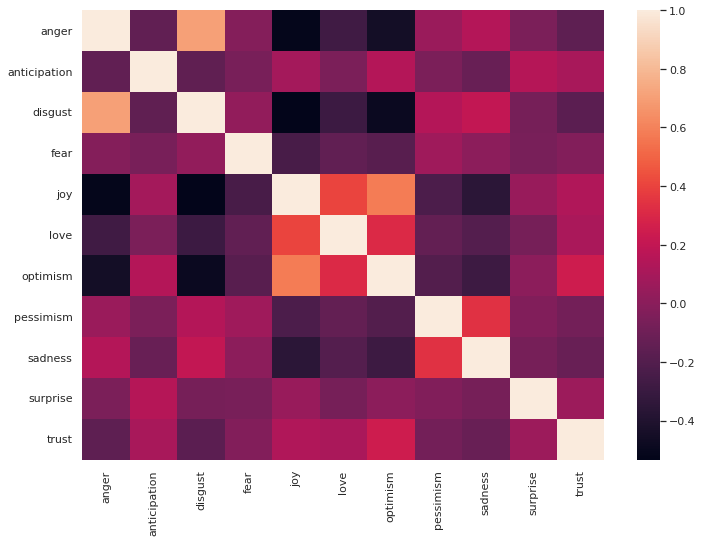

In [2]:
# Dataset exploration
# imports
import pandas as pd
import numpy as np
import seaborn as sns

# Change the filenames accordingly to use the train validaiton and test files respectively
train_filename = '/kaggle/input/semeval2018/2018-E-c-En-train/2018-E-c-En-train.txt'
val_filename = '/kaggle/input/semeval2018/2018-E-c-En-dev/2018-E-c-En-dev.txt'
test_filename = '/kaggle/input/semeval2018/2018-E-c-En-test-gold.txt'

# Read the data from the files to appropriate data frames.
train_df = pd.read_csv(train_filename, sep='\t')
x_train, y_train = train_df.Tweet.values, train_df.iloc[:, 2:].values

val_df = pd.read_csv(val_filename, sep='\t')
x_val, y_val = val_df.Tweet.values, val_df.iloc[:, 2:].values

test_df = pd.read_csv(test_filename, sep='\t')
x_test, y_test = test_df.Tweet.values, test_df.iloc[:, 2:].values

# Concatenate all the label data
y_cat = np.concatenate((y_train, y_val, y_test), axis=0)

# count the number of emotions in each tweet. 0-neutral, 1-single emotion, 2-2 emotions ...
counts = np.zeros((11)) # 11 emotions possible at max
for y in y_cat:
    num_emotions = np.count_nonzero(y)
    counts[num_emotions]+=1

# Original counts as is.
print("Emotion distribution counts:", counts)

# Percentage counts
print("Emotion distribution percentages:", counts/109.83)

# Label correlation on validation set labels.
y_val_df = val_df.iloc[:, 2:]
corr_df = y_val_df.corr(method='kendall')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(corr_df, annot=False)

# Label correlation on the train set labels to be used for the Label Correlation Loss in later sections of the code.
y_train_df = train_df.iloc[:, 2:]
label_graph = train_df.corr(method='kendall')
label_graph = label_graph.to_numpy()

Twitter data preprocessor from the paper: **"Deep lstm with attention for message-level and topic-based sentiment analysis."**

In [3]:
# imports
from torch.utils.data import Dataset
from transformers import BertTokenizer, AutoTokenizer
from tqdm import tqdm
import torch
import pandas as pd
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.classes.preprocessor import TextPreProcessor

def twitter_preprocessor():
    """ preprocess the tweets according to the paper: Deep lstm with attention for message-level and 
    topic-based sentiment analysis.
    Normalizes URLs, usernames, contact info in the tweets,
    tokenizes the data
    """
    preprocessor = TextPreProcessor(
        normalize=['url', 'email', 'phone', 'user'],
        annotate={"hashtag", "elongated", "allcaps", "repeated", 'emphasis', 'censored'},
        all_caps_tag="wrap",
        fix_text=False,
        segmenter="twitter_2018",
        corrector="twitter_2018",
        unpack_hashtags=True,
        unpack_contractions=True,
        spell_correct_elong=False,
        tokenizer=SocialTokenizer(lowercase=True).tokenize).pre_process_doc
    return preprocessor

# Create a preprocess object and keep it ready for use in the dataset class
preprocessor = twitter_preprocessor()

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
/opt/conda/lib/python3.7/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter_2018 - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter_2018/counts_1grams.txt
Reading twitter_2018 - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter_2018/counts_2grams.txt
Reading twitter_2018 - 1grams ...


/opt/conda/lib/python3.7/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Dataset class to train and evaluate the model.
- Reads data from files and preprocess the tweets to tokens
- Runs the tokens through BERT tokenizer to generate IDs for each token and returns a batch of this data.

In [4]:
# Dataset class that reads tweets and labels from the files and prepares batches of data for training, test.
class DataClass(Dataset):
    def __init__(self, args, filename):
        self.args = args
        self.filename = filename
        self.max_length = int(args['--max-length'])
        self.data, self.labels = self.load_dataset()
        
        self.bert_tokeniser = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
        self.inputs, self.lengths, self.label_indices = self.process_data()

    def load_dataset(self):
        """
        :return: dataset after being preprocessed and tokenised
        """
        df = pd.read_csv(self.filename, sep='\t')
        x_train, y_train = df.Tweet.values, df.iloc[:, 2:].values
        return x_train, y_train

    def process_data(self):
        desc = "PreProcessing dataset {}...".format('')
        
        segment_a = "anger anticipation disgust fear joy love optimism hopeless sadness surprise or trust?"
        label_names = ["anger", "anticipation", "disgust", "fear", "joy",
                       "love", "optimism", "hopeless", "sadness", "surprise", "trust"]

        inputs, lengths, label_indices = [], [], []
        for x in tqdm(self.data, desc=desc):
            x = ' '.join(preprocessor(x))
            x = self.bert_tokeniser.encode_plus(segment_a,
                                                x,
                                                add_special_tokens=True,
                                                max_length=self.max_length,
                                                pad_to_max_length=True,
                                                truncation=True)
            input_id = x['input_ids']
            input_length = len([i for i in x['attention_mask'] if i == 1])
            inputs.append(input_id)
            lengths.append(input_length)

            #label indices
            label_idxs = [self.bert_tokeniser.convert_ids_to_tokens(input_id).index(label_names[idx])
                             for idx, _ in enumerate(label_names)]
            label_indices.append(label_idxs)

        inputs = torch.tensor(inputs, dtype=torch.long)
        data_length = torch.tensor(lengths, dtype=torch.long)
        label_indices = torch.tensor(label_indices, dtype=torch.long)
        return inputs, data_length, label_indices

    def __getitem__(self, index):
        inputs = self.inputs[index]
        labels = self.labels[index]
        label_idxs = self.label_indices[index]
        length = self.lengths[index]
        return inputs, labels, length, label_idxs

    def __len__(self):
        return len(self.inputs)

Installing the exact version of transformer is crucial for the model to run.

In [5]:
# package installation for the transformer model
!pip install transformers==3.0.2

### SpanEmo model.
- Contains BERT encoder as the first part of the network. 
- Features from BERT are passed through a feed forward network to generate class probabilities for each class.
- For the label correlation aware loss (joint2), we use the label graph (label-correlation data from the train split) as attention to generate a better mapping in the soft BCE loss.
- See paper: **'Review-Driven Multi-Label Music Style Classification by Exploiting Style Correlations'** for more details on the LCA loss used in 'joint2' loss function.

In [10]:
#from transformers.modeling_bert import BertModel
from transformers import BertModel #, AutoModel
#from transformers.models.bert.modeling_bert import BertModel

import torch.nn.functional as F
import torch.nn as nn
import torch
import transformers 


class BertEncoder(nn.Module):
    def __init__(self):
        super(BertEncoder, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.feature_size = self.bert.config.hidden_size

    def forward(self, input_ids):
        """
        :param input_ids: list[str], list of tokenised sentences
        :return: last hidden representation, torch.tensor of shape (batch_size, seq_length, hidden_dim)
        """
        if int((transformers.__version__)[0]) == 4:
            last_hidden_state = self.bert(input_ids=input_ids).last_hidden_state
        else: #transformers version should be as indicated in the requirements.txt file
            last_hidden_state, pooler_output = self.bert(input_ids=input_ids)
        return last_hidden_state


class SpanEmo(nn.Module):
    def __init__(self, output_dropout=0.1, joint_loss='joint', alpha=0.2):
        """ casting multi-label emotion classification as span-extraction
        :param output_dropout: The dropout probability for output layer
        :param joint_loss: which loss to use cel|corr|cel+corr
        :param alpha: control contribution of each loss function in case of joint training
        """
        super(SpanEmo, self).__init__()
        self.bert = BertEncoder()
        self.joint_loss = joint_loss
        self.alpha = alpha
        
        self.ffn = nn.Sequential(
            nn.Linear(self.bert.feature_size, self.bert.feature_size),
            nn.Tanh(),
            nn.Dropout(p=output_dropout),
            nn.Linear(self.bert.feature_size, 1)
        )
        
        if self.joint_loss == 'joint2':
            # temperature parameter for the soft BCE loss to be used in LCA loss (joint2).
            self.temp = 5.0

            #Label correlation matrix as a parameter. 
            #See eq 5 in paper: Review-Driven Multi-Label Music Style Classification by Exploiting Style Correlations
            self.label_corr = torch.nn.Linear(11, 11, bias=False)
            # Initializing the label graph layer with correlation matrix from train data.
            with torch.no_grad():
                self.label_corr.weight.copy_(torch.tensor(label_graph, dtype=torch.float))

    def forward(self, batch, device):
        """
        :param batch: tuple of (input_ids, labels, length, label_indices)
        :param device: device to run calculations on
        :return: loss, num_rows, y_pred, targets
        """
        #prepare inputs and targets
        inputs, targets, lengths, label_idxs = batch
        inputs, num_rows = inputs.to(device), inputs.size(0)
        label_idxs, targets = label_idxs[0].long().to(device), targets.float().to(device)

        #Bert encoder
        last_hidden_state = self.bert(inputs)

        # FFN---> 2 linear layers---> linear layer + tanh---> linear layer
        # select span of labels to compare them with ground truth ones
        logits = self.ffn(last_hidden_state).squeeze(-1).index_select(dim=1, index=label_idxs)

        #Loss Function
        if self.joint_loss == 'joint':
            cel = F.binary_cross_entropy_with_logits(logits, targets).cuda()
            cl = self.corr_loss(logits, targets)
            loss = ((1 - self.alpha) * cel) + (self.alpha * cl)
        elif self.joint_loss == 'cross-entropy':
            loss = F.binary_cross_entropy_with_logits(logits, targets).cuda()
        elif self.joint_loss == 'corr_loss':
            loss = self.corr_loss(logits, targets)
        # New loss function using label graph training parameter and BCE loss with temperature.
        elif self.joint_loss == 'joint2':
            cel = F.binary_cross_entropy_with_logits(logits, targets).cuda()
            cl = self.lca_loss(logits, targets)
            loss = ((1 - self.alpha) * cel) + (self.alpha * cl)

        y_pred = self.compute_pred(logits)
        return loss, num_rows, y_pred, targets.cpu().numpy()

    def lca_loss(self, y_hat, y_true):
        """ LCA loss that uses the graph_labels to weight the label correlation.
        :param y_hat: output raw probabilities from the model.
        :param y_true: target labels.
        :return lca loss
        """
        #y_hat_dash = torch.matmul(y_hat.sigmoid(), self.label_corr)
        # Matrix multiplication between the label graph and the outputs from the model.
        y_hat_dash = self.label_corr(y_hat.sigmoid())
        
        # Softmax dimension based on the label_corr position in the matrix multiplication.
        label_corr_soft = F.softmax(self.label_corr.weight/self.temp, dim=0)
        y_true_dash = torch.matmul(y_true, label_corr_soft)

        return F.binary_cross_entropy_with_logits(y_hat_dash, y_true_dash).cuda()
    
    @staticmethod
    def corr_loss(y_hat, y_true, reduction='mean'):
        """
        :param y_hat: model predictions, shape(batch, classes)
        :param y_true: target labels (batch, classes)
        :param reduction: whether to avg or sum loss
        :return: loss
        """
        loss = torch.zeros(y_true.size(0)).cuda()
        for idx, (y, y_h) in enumerate(zip(y_true, y_hat.sigmoid())):
            y_z, y_o = (y == 0).nonzero(), y.nonzero()
            if y_o.nelement() != 0:
                output = torch.exp(torch.sub(y_h[y_z], y_h[y_o][:, None]).squeeze(-1)).sum()
                num_comparisons = y_z.size(0) * y_o.size(0)
                loss[idx] = output.div(num_comparisons)
        return loss.mean() if reduction == 'mean' else loss.sum()
        
    @staticmethod
    def compute_pred(logits, threshold=0.5):
        """
        :param logits: model predictions
        :param threshold: threshold value
        :return:
        """
        y_pred = torch.sigmoid(logits) > threshold
        return y_pred.float().cpu().numpy()

### Training and Testing utils

Next, we define trainer, early stopper classes to help run the training, validation, and early stopping if the validation loss doesn't go down after a set number of epochs.
- EarlyStopper:
    - Checks if the validation loss is less than previous epoch, if yes saves the checkpoint if not, increments the early stop counter.
    - When the early stop counter reaches 10, the training is terminated.
- Trainer:
    - Creates an optimizer with different learning rates for BERT, FFN, and the label graph parameters to optimize them.
    - Optimize the model by running back propogation on the combined loss function.
    - Predict emotions from a given tweet and return the logits.
- Evaluate:
    - Runs the model on the entire test/validation data and generates F1-micro/macro, jaccard score metrics.

In [7]:
from fastprogress.fastprogress import format_time, master_bar, progress_bar
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, jaccard_score
import torch.nn.functional as F
import numpy as np
import torch
import time


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience.
    Taken from https://github.com/Bjarten/early-stopping-pytorch"""

    def __init__(self, filename, patience=7, verbose=True, delta=0):
        """
        :param patience: How long to wait after last time validation loss improved.
        :param verbose: If True, prints a message for each validation loss improvement.
        :param delta: Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.cur_date = filename

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), '/kaggle/working/' + self.cur_date + '_checkpoint.pt')
        self.val_loss_min = val_loss


class Trainer(object):
    """
    Class to encapsulate training and validation steps for a pipeline. Based off the "Tonks Library"
    :param model: PyTorch model to use with the Learner
    :param train_data_loader: dataloader for all of the training data
    :param val_data_loader: dataloader for all of the validation data
    :param filename: the best model will be saved using this given name (str)
    """

    def __init__(self, model, train_data_loader, val_data_loader, filename):
        self.model = model
        self.train_data_loader = train_data_loader
        self.val_data_loader = val_data_loader
        self.filename = filename
        self.early_stop = EarlyStopping(self.filename, patience=10)

    def fit(self, num_epochs, args, device='cuda:0'):
        """
        Fit the PyTorch model
        :param num_epochs: number of epochs to train (int)
        :param args:
        :param device: str (defaults to 'cuda:0')
        """
        optimizer, scheduler, step_scheduler_on_batch = self.optimizer(args)
        self.model = self.model.to(device)
        pbar = master_bar(range(num_epochs))
        headers = ['Train_Loss', 'Val_Loss', 'F1-Macro', 'F1-Micro', 'JS', 'Time']
        pbar.write(headers, table=True)
        for epoch in pbar:
            epoch += 1
            start_time = time.time()
            self.model.train()
            overall_training_loss = 0.0
            for step, batch in enumerate(progress_bar(self.train_data_loader, parent=pbar)):
                loss, num_rows, _, _ = self.model(batch, device)
                overall_training_loss += loss.item() * num_rows

                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
                if step_scheduler_on_batch:
                    scheduler.step()
                optimizer.zero_grad()

            if not step_scheduler_on_batch:
                scheduler.step()

            overall_training_loss = overall_training_loss / len(self.train_data_loader.dataset)
            overall_val_loss, pred_dict = self.predict(device, pbar)
            y_true, y_pred = pred_dict['y_true'], pred_dict['y_pred']

            str_stats = []
            stats = [overall_training_loss,
                     overall_val_loss,
                     f1_score(y_true, y_pred, average="macro"),
                     f1_score(y_true, y_pred, average="micro"),
                     jaccard_score(y_true, y_pred, average="samples")]

            for stat in stats:
                str_stats.append(
                    'NA' if stat is None else str(stat) if isinstance(stat, int) else f'{stat:.4f}'
                )
            str_stats.append(format_time(time.time() - start_time))
            print('epoch#: ', epoch)
            pbar.write(str_stats, table=True)
            self.early_stop(overall_val_loss, self.model)
            if self.early_stop.early_stop:
                print("Early stopping")
                break
                
    def optimizer(self, args):
        """
        :param args: object
        """
        optimizer = AdamW([
            {'params': self.model.bert.parameters()},
            {'params': self.model.label_corr.parameters()},
            {'params': self.model.ffn.parameters(),
             'lr': float(args['--ffn-lr'])},
        ], lr=float(args['--bert-lr']), correct_bias=True)
        num_train_steps = (int(len(self.train_data_loader.dataset)) /
                           int(args['--train-batch-size'])) * int(args['--max-epoch'])
        num_warmup_steps = int(num_train_steps * 0.1)
        scheduler = get_linear_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=num_warmup_steps,
                                                    num_training_steps=num_train_steps)
        step_scheduler_on_batch = True
        return optimizer, scheduler, step_scheduler_on_batch

    def predict(self, device='cuda:0', pbar=None):
        """
        Evaluate the model on a validation set
        :param device: str (defaults to 'cuda:0')
        :param pbar: fast_progress progress bar (defaults to None)
        :returns: overall_val_loss (float), accuracies (dict{'acc': value}, preds (dict)
        """
        current_size = len(self.val_data_loader.dataset)
        preds_dict = {
            'y_true': np.zeros([current_size, 11]),
            'y_pred': np.zeros([current_size, 11])
        }
        overall_val_loss = 0.0
        self.model.eval()
        with torch.no_grad():
            index_dict = 0
            for step, batch in enumerate(progress_bar(self.val_data_loader, parent=pbar, leave=(pbar is not None))):
                loss, num_rows, y_pred, targets = self.model(batch, device)
                overall_val_loss += loss.item() * num_rows

                current_index = index_dict
                preds_dict['y_true'][current_index: current_index + num_rows, :] = targets
                preds_dict['y_pred'][current_index: current_index + num_rows, :] = y_pred
                index_dict += num_rows

        overall_val_loss = overall_val_loss / len(self.val_data_loader.dataset)
        return overall_val_loss, preds_dict

class EvaluateOnTest(object):
    """
    Class to encapsulate evaluation on the test set. Based off the "Tonks Library"
    :param model: PyTorch model to use with the Learner
    :param test_data_loader: dataloader for all of the validation data
    :param model_path: path of the trained model
    """
    def __init__(self, model, test_data_loader, model_path):
        self.model = model
        self.test_data_loader = test_data_loader
        self.model_path = model_path

    def predict(self, device='cuda:0', pbar=None):
        """
        Evaluate the model on a validation set
        :param device: str (defaults to 'cuda:0')
        :param pbar: fast_progress progress bar (defaults to None)
        :returns: None
        """
        self.model.to(device).load_state_dict(torch.load(self.model_path))
        self.model.eval()
        current_size = len(self.test_data_loader.dataset)
        preds_dict = {
            'y_true': np.zeros([current_size, 11]),
            'y_pred': np.zeros([current_size, 11])
        }
        start_time = time.time()
        with torch.no_grad():
            index_dict = 0
            for step, batch in enumerate(progress_bar(self.test_data_loader, parent=pbar, leave=(pbar is not None))):
                _, num_rows, y_pred, targets = self.model(batch, device)
                current_index = index_dict
                preds_dict['y_true'][current_index: current_index + num_rows, :] = targets
                preds_dict['y_pred'][current_index: current_index + num_rows, :] = y_pred
                index_dict += num_rows

        y_true, y_pred = preds_dict['y_true'], preds_dict['y_pred']
        str_stats = []
        stats = [f1_score(y_true, y_pred, average="macro"),
                 f1_score(y_true, y_pred, average="micro"),
                 jaccard_score(y_true, y_pred, average="samples")]

        for stat in stats:
            str_stats.append(
                'NA' if stat is None else str(stat) if isinstance(stat, int) else f'{stat:.4f}'
            )
        str_stats.append(format_time(time.time() - start_time))
        headers = ['F1-Macro', 'F1-Micro', 'JS', 'Time']
        print(' '.join('{}: {}'.format(*k) for k in zip(headers, str_stats)))

### Train
- Main code block that sets the parameters for training. Calls the trainer object to run the training.
- Checkpoints are saved in the 'kaggle/working/' directory based on the time and date of the experiment.

In [8]:
"""
Options:
    --loss-type=<str>                 Which loss to use cross-entropy|corr_loss|joint. [default: joint]
    --max-length=<int>                text length [default: 128]
    --output-dropout=<float>          prob of dropout applied to the output layer [default: 0.1]
    --seed=<int>                      fixed random seed number [default: 42]
    --train-batch-size=<int>          batch size [default: 32]
    --eval-batch-size=<int>           batch size [default: 32]
    --max-epoch=<int>                 max epoch [default: 20]
    --ffn-lr=<float>                  ffn learning rate [default: 0.001]
    --bert-lr=<float>                 bert learning rate [default: 2e-5]
    --dev-path=<str>                  file path of the dev set [default: '/semeval2018/2018-E-c-En-dev/2018-E-c-En-dev.txt']
    --train-path=<str>                file path of the train set [default: '/semeval2018/2018-E-c-En-train/2018-E-c-En-train.txt']
    --alpha-loss=<float>              weight used to balance the loss [default: 0.2]
"""

from torch.utils.data import DataLoader
import torch
import datetime
import json
import numpy as np

# making arg parser as a dictionary to run in a notebook.
args = {}
args['--loss-type'] = 'joint2' #'joint' #'corr_loss' #'cross-entropy' #'joint'
args['--max-length'] = int(128)
args['--output-dropout'] = 0.1
args['--seed'] = 42
args['--train-batch-size'] = int(32)
args['--eval-batch-size'] = int(32)
args['--max-epoch'] = int(20)
args['--ffn-lr'] = 0.001
args['--bert-lr'] = 2e-5
args['--dev-path'] = '../input/semeval2018/2018-E-c-En-dev/2018-E-c-En-dev.txt'
args['--train-path'] = '../input/semeval2018/2018-E-c-En-train/2018-E-c-En-train.txt'
args['--alpha-loss'] = 0.2


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if str(device) == 'cuda:0':
    print("Currently using GPU: {}".format(device))
    np.random.seed(int(args['--seed']))
    torch.cuda.manual_seed_all(int(args['--seed']))
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    print("Currently using CPU")

#####################################################################
# Save hyper-parameter values ---> config.json
# Save model weights ---> filename.pt using current time
#####################################################################
now = datetime.datetime.now()
filename = now.strftime("%Y-%m-%d-%H:%M:%S")
fw = open('/kaggle/working/' + filename + '.json', 'a')
model_path = '/kaggle/working/'+ filename + '.pt'
args['--checkpoint-path'] = model_path
json.dump(args, fw, sort_keys=True, indent=2)

#####################################################################
# Define Dataloaders
#####################################################################
train_dataset = DataClass(args, args['--train-path'])
train_data_loader = DataLoader(train_dataset,
                               batch_size=int(args['--train-batch-size']),
                               shuffle=True
                               )
print('The number of training batches: ', len(train_data_loader))
dev_dataset = DataClass(args, args['--dev-path'])
dev_data_loader = DataLoader(dev_dataset,
                             batch_size=int(args['--eval-batch-size']),
                             shuffle=False
                             )
print('The number of validation batches: ', len(dev_data_loader))

#############################################################################
# Define Model & Training Pipeline
#############################################################################
model = SpanEmo(output_dropout=float(args['--output-dropout']),
                joint_loss=args['--loss-type'],
                alpha=float(args['--alpha-loss']))

#############################################################################
# Start Training
#############################################################################
learn = Trainer(model, train_data_loader, dev_data_loader, filename=filename)
learn.fit(
    num_epochs=int(args['--max-epoch']),
    args=args,
    device=device
)

Currently using GPU: cuda:0


PreProcessing dataset ...: 100%|██████████| 6838/6838 [00:18<00:00, 365.75it/s]


The number of training batches:  214


PreProcessing dataset ...: 100%|██████████| 886/886 [00:02<00:00, 375.84it/s]


The number of validation batches:  28


Train_Loss,Val_Loss,F1-Macro,F1-Micro,JS,Time
0.5138,0.4222,0.4592,0.6522,0.5162,01:24
0.4134,0.4078,0.5182,0.6968,0.5691,01:23
0.3797,0.3948,0.5236,0.6906,0.5638,01:23


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch#:  1
Validation loss decreased (inf --> 0.422159).  Saving model ...


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch#:  2
Validation loss decreased (0.422159 --> 0.407821).  Saving model ...


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch#:  3
Validation loss decreased (0.407821 --> 0.394753).  Saving model ...


KeyboardInterrupt: 

### Test

- Code block to test the model accuracy on test data.
- Runs the model on the entire test/validation dataset and reports the three metrics.
- Trained models' file paths are already in the code, uncomment the one to test and comment the rest.

In [11]:
from torch.utils.data import DataLoader
import torch
import numpy as np

args={}
# Base model - SpanEmo paper
args['--model-path'] = '/kaggle/working/2022-11-23-14:24:40_checkpoint.pt'
# Ablation model - with only BCE loss training
#args['--model-path'] = '/kaggle/working/2022-11-24-22:41:42_checkpoint.pt'
# Ablation model with only LCA loss training
#args['--model-path'] = '/kaggle/working/2022-12-07-23:46:25_checkpoint.pt'
# Model with own LCA loss
#args['--model-path'] = '/kaggle/working/2022-12-11-03:23:01_checkpoint.pt'

#Ensure same max-length is used as training.
args['--max-length'] = int(128)
args['--seed'] = int(0) 
args['--test-batch-size'] = int(16)
args['--test-path'] = '/kaggle/input/semeval2018/2018-E-c-En-test-gold.txt'

#args = docopt(__doc__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if str(device) == 'cuda:0':
    print("Currently using GPU: {}".format(device))
    np.random.seed(int(args['--seed']))
    torch.cuda.manual_seed_all(int(args['--seed']))
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    print("Currently using CPU")

    
#####################################################################
# Define Dataloaders
#####################################################################
test_dataset = DataClass(args, args['--test-path'])
test_data_loader = DataLoader(test_dataset,
                              batch_size=int(args['--test-batch-size']),
                              shuffle=False)
print('The number of Test batches: ', len(test_data_loader))

        
#############################################################################
# Run the model on a Test set
#############################################################################
model = SpanEmo()
learn = EvaluateOnTest(model, test_data_loader, model_path=args['--model-path'])
learn.predict(device=device)

Currently using GPU: cuda:0


PreProcessing dataset ...: 100%|██████████| 3259/3259 [00:08<00:00, 384.27it/s]


The number of Test batches:  204


F1-Macro: 0.5724 F1-Micro: 0.7107 JS: 0.5938 Time: 00:13


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
